<h1 style="text-align: center">Kaggle Titanic Dataset</h1>
<h3 style="text-align: center">Predicting passenger survival</h3>


In [266]:
import numpy as np
import matplotlib.pyplot as plt
import csv as csv
from IPython.display import clear_output

ALPHA = 0.00001
ESPILON = 0.00001
TRAIN_DATA_FILE = "train.csv"
TEST_DATA_FILE = "test.csv"
DATA_OUTPUT_NAME = "answers.csv"

UNKNOWN_AGE_INSERT = 30 # This is the assumption for the passenger if the age is unknown.

## Fetching and Organizing Data

#### Raw Passenger Data
Passenger Data is returned as a list of strings, in the order of the following:
*Passenger Id, Survived, Pclass, Name, Sex, Age, SibSp, Parch, Ticket, Fare, Cabin, Embarked*

#### Parsed Passenger Data
Passenger Data needs to be parsed and converted into numbers for the machine learning algorithms to take over. The following will be the parsing scheme. This will also be the order as well

1. **Passenger Id**: This will stay the same, nor will be converted into an int.
2. **Survived**: 0 for died, 1 for survived
3. **Pclass**: 1 for upper class, 2 for middle class, 3 for lower class
4. **Sex**: 0 for Male, 1 for Female
5. **Age**: Float from the string, if it is an empty string then going to default to age of 30 (arbitrary).
6. **SibSp**: Sibling/Spouse on board, staying the same.
7. **Parch**: # of Parent/Children on board, staying the same.
8. **Fare**: Convert to a float

In [267]:
def FetchPassengerData(fileName: str) -> list:
    """Gets the information and then returns a list of the passengers in the format shown below (as strings)

    Args:
        fileName (str): The csv file to open

    Returns:
        list: PassengerId, Survived, Pclass, Name, Sex, Age, SibSp, Parch, Ticket, Fare, Cabin, Embarked 
    """
    result = []
    with open(fileName, newline='') as csvfile:
        reader = csv.reader(csvfile, delimiter=',')
        for row in reader:
            result.append(row)
    return result

def ParseSurvived(survived: str) -> int:
    try:
        return int(float(survived))
    except Exception as ex:
        print(str(ex))
        return 0


def ParseAge(age: str) -> int:
    try:
        return float(age) / 100
    except ValueError:
        return UNKNOWN_AGE_INSERT / 100

def ParseFare(fare, pclass):
    try:
        if fare == '':
            if pclass == 1:
                return 70 / 100
            elif pclass == 2:
                return 25 / 100
            else:
                return 7.25 / 100
        else:
            return float(fare)
    except ValueError:
        print("Parseing fare went wrong.")
        return 7.25 / 100
    except Exception as ex:
        print(f"ParseFare error: {ex}")
        return 7.25 / 100

def ParseCabin(cabin):
    for a in cabin:
        if a == 'A':
            return 1
        elif a == 'B':
            return 2
        elif a == 'C':
            return 3
        elif a == 'D':
            return 4
        elif a == 'E':
            return 5
        elif a == 'F':
            return 6
        
    return 0

def ParseEmbarked(embarked):
    if embarked == 'C':
        return 1
    elif embarked == 'Q':
        return 2
    elif embarked == 'S':
        return 3
    else:
        return 0

def ParsePassengerData(passenger: list) -> list:
    """Takes passenger data and converts all the types to be usable for the machine learning. See the paragraph above for the information.
     

    Args:
        passenger (list): PassengerId, Survived (optional), Pclass, Name, Sex, Age, SibSp, Parch, Ticket, Fare, Cabin, Embarked

    Returns:
        list: PassengerId, Survived, Pclass, Sex, Age, SibSp, Parch, Fare
    """
    try:
        # Passenger surviving wasn't added. Add a '0' for survivied (mirroring test data)
        if len(passenger) < 12:
            passenger.insert(1, '0')
        
        if len(passenger) < 12:
            print("List is less than 12 elements still.")
            print(f"Passenger: {passenger}")
            raise Exception(ValueError)
        
        PassengerId = float(passenger[0])
        Survived = float(ParseSurvived(passenger[1]))
        Pclass = float(passenger[2])
        #  Name is irrelevant (passenger[3])
        Sex = float(passenger[4] == 'female')
        Age = ParseAge(passenger[5])
        SibSp = float(passenger[6])
        Parch = float(passenger[7])
        # Ticket is irrelevant (passenger[8])
        Fare = ParseFare(passenger[9], Pclass)
        # Cabin will be relevant -- going to eventually make up a scheme and numbering system based general cabin location.
        Cabin = ParseCabin(passenger[10])
        # I doubt embarked will matter, might be worth adding later.
        Embarked = ParseEmbarked(passenger[11])
    except ValueError:
        print("Value Error")
        print(f"Passenger: {passenger}")
        raise Exception(ValueError)

    return [PassengerId, Survived, Sex,
            Pclass * Pclass * Pclass,
            Pclass * Pclass,
            Parch * Parch,
            Age * Age,
            Pclass,   
            Age, 
            SibSp,
            Parch,
            Fare, 
            Cabin,
            Embarked
            ]


In [268]:
Data = [ParsePassengerData(passenger=passenger) for passenger in FetchPassengerData(TRAIN_DATA_FILE)[1:]]
Males = 0
Females = 0
for passenger in Data:
    if passenger[2] == 0:
        Males += 1
    else:
        Females += 1

print(f"Males: {Males}\nFemales: {Females}")

Males: 577
Females: 314


### Training Function (and running)

In [269]:
def MakePredictions(TestData, W_HAT, B):
    Correct = 0
    Wrong = 0

    for passenger in TestData:
        Prediction = np.dot(passenger[3:], W_HAT) + B
        if Prediction > 0.5:
            Guess = True
        else:
            Guess = False
        
        if bool(passenger[1]) == Guess:
            Correct += 1
        else:
            Wrong += 1
    
    return Correct / (Correct + Wrong)

def TrainData(gender: bool):
    """Trains the data, 

    Args:
        gender (bool): The gender, false for male, true for female

    Returns:
        _type_: _description_
    """
    TrainRawData = FetchPassengerData(TRAIN_DATA_FILE) # Fetchin the raw data from the CSV file
    TempAllTrainData = [np.array(ParsePassengerData(passenger)) for passenger in TrainRawData[1:]] # The data parsed to use to train
    AllTrainData = []
    for passenger in TempAllTrainData: # Genderfy the data
        if passenger[2] == float(gender):
            AllTrainData.append(passenger)
    NumAttributes = len(AllTrainData[0]) # Number of Characteristics
    NumTotalPassengers = len(AllTrainData) # Number of Passengers

    TrainData = AllTrainData[:(int(NumTotalPassengers * 0.9))]
    TestData = AllTrainData[NumTotalPassengers - (int(NumTotalPassengers * 0.1)):]
    NumPassengers = len(TrainData)

    W_HAT = np.array([int(0) for i in range(NumAttributes - 3)]) # W_HAT all 0's for characteristics of Passenger Data
    B = 1 # Correction number
    HIST_COST = []
    HIST_J = [] # History of the derivative (used to check alpha)
    HIST_TEST = []
    ITERATION = 0 # Current Iteration Count
    MaxAccuracy = 0
    BEST_W_HAT = []
    PreviousCost = 1000 # Arbitrarily set, will change
    CostDifference = 1000 # Arbitrarily set

    print("Starting...")
    # Loop either for 100000 iterations or until the rate of change is less than or equal to ESPILON
    while ITERATION < 100000 and CostDifference >= ESPILON:
        ITERATION += 1
        W_HAT_TEMP = []
        temp_dj_dws = []

        for index in range(NumAttributes - 3):
            sum = 0
            for passenger in TrainData:
                # sum += (np.dot(passenger[2:], W_HAT) + B) * passenger[2 + index]
                    sum += ( (np.dot(passenger[3:], W_HAT) + B) - passenger[1] ) * passenger[3 + index]
            dj_dw = sum / NumPassengers
            W_HAT_TEMP.append(W_HAT[index] - (ALPHA * dj_dw))
            temp_dj_dws.append(dj_dw)

        temp_B = B
        for passenger in TrainData:
            sum += (np.dot(passenger[3:], W_HAT) + B) - passenger[1]
        dj_db = sum / NumPassengers
        temp_B = B - (ALPHA * dj_db)
        
        #Update W_Hat and B
        W_HAT = np.array(W_HAT_TEMP)
        B = temp_B

        # Test the data
        Accuracy = MakePredictions(TestData, W_HAT, B)

        if Accuracy > MaxAccuracy:
            MaxAccuracy = Accuracy
            BEST_W_HAT = np.array(W_HAT)


        if ITERATION % 1000 == 0:
            AccuracyView = "{:.1f}%".format(Accuracy * 100)
            MaxAccuracyView = "{:.1f}%".format(MaxAccuracy * 100)
            clear_output(wait=True)
            print(f"\nIteration {ITERATION}: \n\tCost ({cost}) \n\tAccuracy: {AccuracyView}\n\tHighest Accuracy: {MaxAccuracyView}\n\tW_Hat: {W_HAT}\n\tB: {B} ")

        #Save History every 1000 trials
        if ITERATION % 100 == 0:
            HIST_J.append(temp_dj_dws.append(dj_db))
            HIST_TEST.append(Accuracy)

            # Calculate the current cost
            cost = 0
            temp_cost = 0
            for passenger in TrainData:
                temp_cost = (np.dot(passenger[3:], W_HAT) + B) - passenger[1]
                cost += temp_cost * temp_cost

            cost = cost / (2 * NumPassengers)

            HIST_COST.append(cost)
            CostDifference = PreviousCost - cost
            PreviousCost = cost

    #Post training loop
    AccuracyView = "{:.1f}%".format(Accuracy * 100)
    print(f"Iteration: {ITERATION}")
    print(f"\nNumber of Iterations: {ITERATION}")
    print(f"W_Hat: {W_HAT}")
    print(f"B = {B}")
    print(f"Accuracy: {AccuracyView}")
    return BEST_W_HAT, B, HIST_COST, HIST_J, HIST_TEST 

In [270]:
mW_HAT, mB, mHIST_COST, mHIST_J, mHIST_TEST = TrainData(gender=False) # Male


Iteration 64000: 
	Cost (0.07704640813014565) 
	W_Hat: [ 0.00669769 -0.05397594  0.00582265 -0.01049496 -0.05347615 -0.02228505
 -0.00197628  0.0077963  -0.00091799 -0.00470521 -0.09842225]
	B: 0.8586303620536517 
	Accuracy: 86.0%
	Highest Accuracy: 87.7%
Iteration: 64800

Number of Iterations: 64800
W_Hat: [ 0.00689345 -0.05426669  0.00581545 -0.01057953 -0.05379925 -0.02245873
 -0.00199355  0.00787756 -0.00090863 -0.00444447 -0.09878966]
B = 0.857993976753946
Accuracy: 86.0%


In [271]:
fW_HAT, fB, fHIST_COST, fHIST_J, fHIST_TEST = TrainData(gender=True) # Female


Iteration 7000: 
	Cost (0.06956226519729396) 
	W_Hat: [-1.51716691e-02 -3.18370990e-03 -1.02112898e-02 -4.59256521e-05
 -1.06391793e-04 -2.70973252e-05 -5.30119942e-03 -2.90100097e-03
 -2.18224475e-05  1.05805998e-03 -1.52682414e-03]
	B: 0.998933222624904 
	Accuracy: 77.4%
	Highest Accuracy: 77.4%
Iteration: 7900

Number of Iterations: 7900
W_Hat: [-1.52087916e-02 -2.95139257e-03 -1.08202120e-02 -4.67732066e-05
  9.12782714e-05 -1.48246240e-05 -5.87775639e-03 -3.08632017e-03
 -1.71431940e-05  1.16076464e-03 -1.53340525e-03]
B = 0.9990505322167328
Accuracy: 77.4%


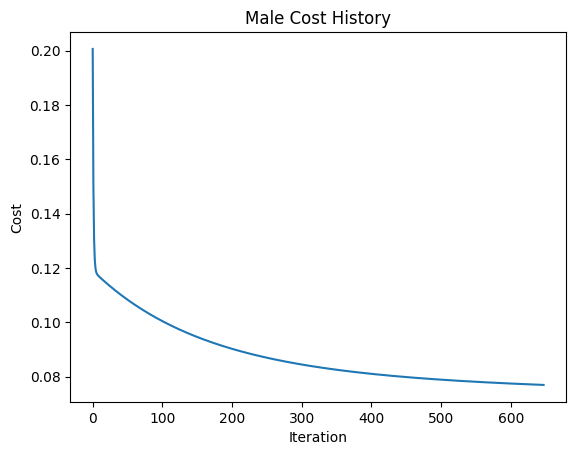

In [272]:
plt.plot(mHIST_COST)
plt.title("Male Cost History")
plt.xlabel("Iteration")
plt.ylabel("Cost")
plt.show()

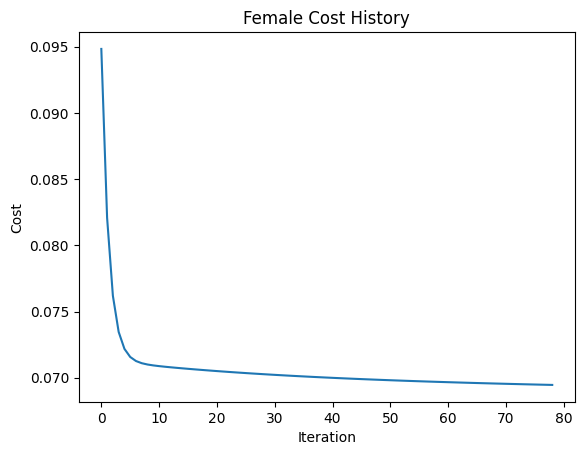

In [273]:
plt.plot(fHIST_COST)
plt.title("Female Cost History")
plt.xlabel("Iteration")
plt.ylabel("Cost")
plt.show()

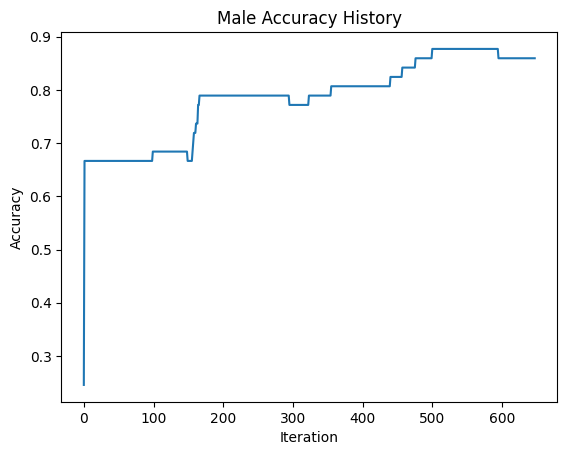

In [274]:
plt.plot(mHIST_TEST)
plt.title("Male Accuracy History")
plt.xlabel("Iteration")
plt.ylabel("Accuracy")
plt.show()

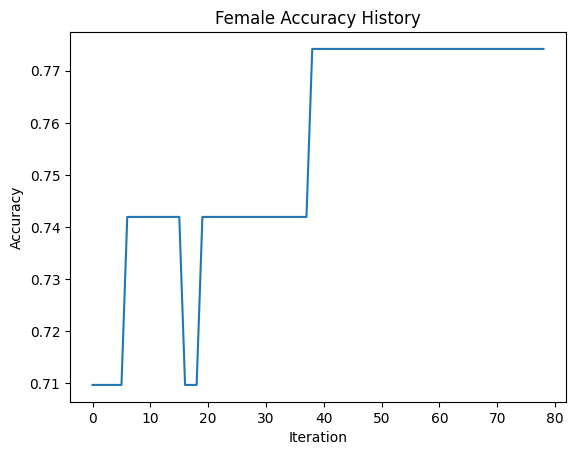

In [275]:
plt.plot(fHIST_TEST)
plt.title("Female Accuracy History")
plt.xlabel("Iteration")
plt.ylabel("Accuracy")
plt.show()

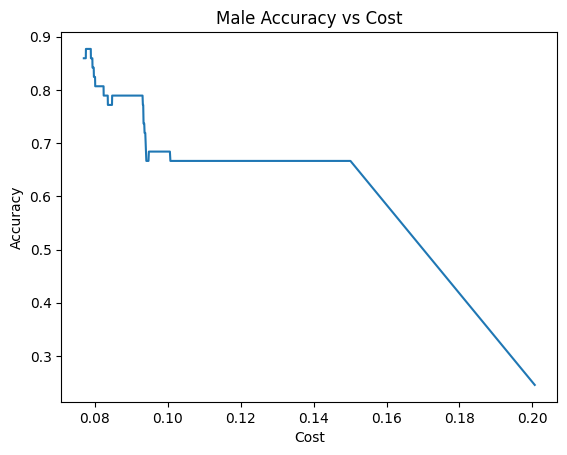

In [276]:
plt.plot(mHIST_COST, mHIST_TEST)
plt.title("Male Accuracy vs Cost")
plt.xlabel("Cost")
plt.ylabel("Accuracy")
plt.show()

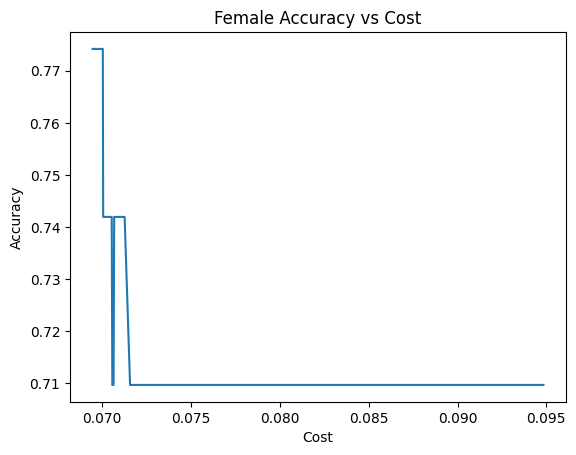

In [277]:
plt.plot(fHIST_COST, fHIST_TEST)
plt.title("Female Accuracy vs Cost")
plt.xlabel("Cost")
plt.ylabel("Accuracy")
plt.show()

In [278]:
# Testing the formula
def MakePredictions(maleW_HAT, femaleW_HAT):
    TestRawData = FetchPassengerData(TEST_DATA_FILE) # Fetchin the raw data from the CSV file
    TestData = [np.array(ParsePassengerData(passenger)) for passenger in TestRawData[1:]] # The data parsed to use to train
    PredictionList = []

    for passenger in TestData:
        if passenger[2] == 0:
            Prediction = np.dot(passenger[3:], mW_HAT) + mB
        else:
            Prediction = np.dot(passenger[3:], fW_HAT) + fB

        if Prediction > 0.5:
            Guess = True
        else:
            Guess = False
        
        PredictionList.append((passenger[0], Prediction, Guess))
    
    return PredictionList

Predictions = MakePredictions(mW_HAT, fW_HAT)

In [279]:
def WriteAnswersCSVFile(fname, PredictionList):

    with open(fname, 'w', newline='') as csvfile:
        writer = csv.writer(csvfile, delimiter=',')
        writer.writerow(['PassengerId', 'Survived'])

        for pred in PredictionList:
            result = [str(int(pred[0]))]
            if pred[2]:
                result.append('1')
            else:
                result.append('0')
            
            writer.writerow(result)

WriteAnswersCSVFile('submission.csv', Predictions)

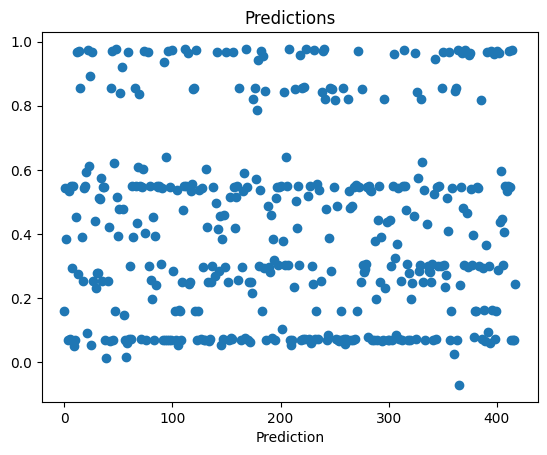

In [280]:
predictionsOnly = [pred[1] for pred in Predictions]
plt.scatter([i for i in range(len(predictionsOnly))], predictionsOnly)
plt.title("Predictions")
plt.xlabel("Prediction")
plt.show()